# Phase 1

Our goal in this projet is to "reverse-engineer" the number of bike rentals that happened during the years in focus.
A high percentage of predictions will show that the program can correctly preview the number of bike rentals the company will need in the future allowing for better management.

## Import files

In [1]:
from google.colab import files

print("Por favor, faça o upload de um arquivo CSV:")
uploaded = files.upload()

if uploaded:
  for fn in uploaded.keys():
    print(f'User uploaded file "{fn}" with length {len(uploaded[fn])} bytes')
else:
  print("Nenhum arquivo foi selecionado ou o upload foi cancelado.")


Por favor, faça o upload de um arquivo CSV:


Saving hour.csv to hour.csv
User uploaded file "hour.csv" with length 1156736 bytes


# Phase 2

Import libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import joblib


## Understanding the data

### Variables Index

- instant: record index
- dteday : date
- season : season (1:springer, 2:summer, 3:fall, 4:winter)
- yr : year (0: 2011, 1:2012)
- mnth : month ( 1 to 12)
- hr : hour (0 to 23)
- holiday : weather day is holiday or not (extracted from http://dchr.dc.gov/page/holiday-schedule)
- weekday : day of the week
- workingday : if day is neither weekend nor holiday is 1, otherwise is 0.
+ weathersit :
	- 1: Clear, Few clouds, Partly cloudy, Partly cloudy
	- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
	- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
  - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
- temp : Normalized temperature in Celsius. The values are divided to 41 (max)
- atemp: Normalized feeling temperature in Celsius. The values are divided to 50 (max)
- hum: Normalized humidity. The values are divided to 100 (max)
- windspeed: Normalized wind speed. The values are divided to 67 (max)
- casual: count of casual users
- registered: count of registered users
- cnt: count of total rental bikes including both casual and registered

Due to the details on the file we can already know that the dataset shows the numeber of bike rentals in the period of 2 years, having in mind weather, temperature, humidity and windspeed.
We intend to further analysis the variables in order to understand if there are correlations between them, that are not so easy to perceive.

In [3]:
df = pd.read_csv(fn)

In [4]:
df.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     17379 non-null  int64  
 1   dteday      17379 non-null  object 
 2   season      17379 non-null  int64  
 3   yr          17379 non-null  int64  
 4   mnth        17379 non-null  int64  
 5   hr          17379 non-null  int64  
 6   holiday     17379 non-null  int64  
 7   weekday     17379 non-null  int64  
 8   workingday  17379 non-null  int64  
 9   weathersit  17379 non-null  int64  
 10  temp        17379 non-null  float64
 11  atemp       17379 non-null  float64
 12  hum         17379 non-null  float64
 13  windspeed   17379 non-null  float64
 14  casual      17379 non-null  int64  
 15  registered  17379 non-null  int64  
 16  cnt         17379 non-null  int64  
dtypes: float64(4), int64(12), object(1)
memory usage: 2.3+ MB


In [6]:
df.describe()

,instant,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,17379.0000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,8690.0000,2.501640,0.502561,6.537775,11.546752,0.028770,3.003683,0.682721,1.425283,0.496987,0.475775,0.627229,0.190098,35.676218,153.786869,189.463088
std,5017.0295,1.106918,0.500008,3.438776,6.914405,0.167165,2.005771,0.465431,0.639357,0.192556,0.171850,0.192930,0.122340,49.305030,151.357286,181.387599
min,1.0000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,4345.5000,2.000000,0.000000,4.000000,6.000000,0.000000,1.000000,0.000000,1.000000,0.340000,0.333300,0.480000,0.104500,4.000000,34.000000,40.000000
50%,8690.0000,3.000000,1.000000,7.000000,12.000000,0.000000,3.000000,1.000000,1.000000,0.500000,0.484800,0.630000,0.194000,17.000000,115.000000,142.000000
75%,13034.5000,3.000000,1.000000,10.000000,18.000000,0.000000,5.000000,1.000000,2.000000,0.660000,0.621200,0.780000,0.253700,48.000000,220.000000,281.000000
max,17379.0000,4.000000,1.000000,12.000000,23.000000,1.000000,6.000000,1.000000,4.000000,1.000000,1.000000,1.000000,0.850700,367.000000,886.000000,977.000000


In [7]:
# The 'cnt' column should be always the sum of "causal" and "registered"

df['calculated_cnt'] = df['casual'] + df['registered']
is_cnt_sum = (df['cnt'] == df['calculated_cnt']).all()

if is_cnt_sum:
    print("The column 'cnt' is always the sum between 'causal' and 'registered'.")
else:
    print("The sum between 'registered' and 'casual' doesn't always adds up to 'cnt'.")

The column 'cnt' is always the sum between 'causal' and 'registered'.


We can already see that the dataset doesnt' havey any nulls, facilitating our process of cleaning and preparation.

### Exploratory Data Analysis

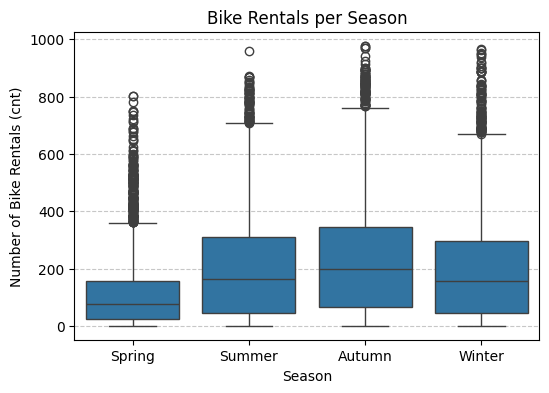

In [8]:
# Graph that compares Bike rentals with Seasons

plt.figure(figsize=(6, 4))
sns.boxplot(x='season', y='cnt', data=df)
plt.title('Bike Rentals per Season')
plt.xlabel('Season')
plt.ylabel('Number of Bike Rentals (cnt)')
plt.xticks(ticks=[0, 1, 2, 3], labels=['Spring', 'Summer', 'Autumn', 'Winter'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


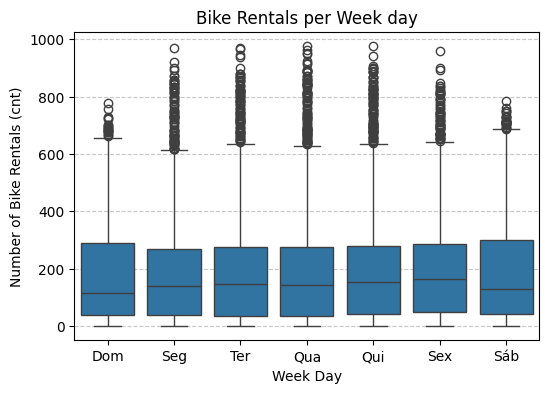

In [9]:
# Graph that compares Bike rentals with Weekdays
# NOTE that by analyzing the date we can see that the week day 1 - corresponds to a Sunday, 2 - Monday, (...)

plt.figure(figsize=(6, 4))
sns.boxplot(x='weekday', y='cnt', data=df)
plt.title('Bike Rentals per Week day')
plt.xlabel('Week Day')
plt.ylabel('Number of Bike Rentals (cnt)')
plt.xticks(ticks=[0, 1, 2, 3, 4, 5, 6], labels=['Dom', 'Seg', 'Ter', 'Qua', 'Qui', 'Sex', 'Sáb'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


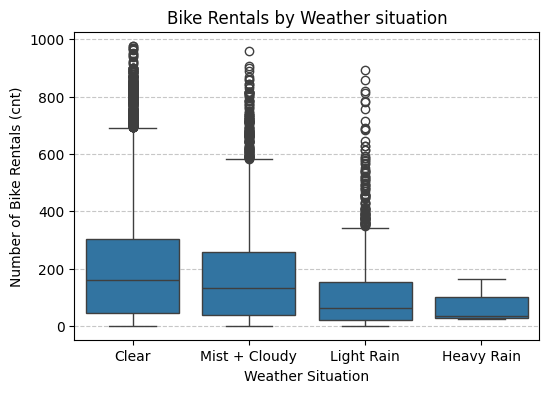

In [10]:
# Graph that compares Bike rentals with the Weather

plt.figure(figsize=(6, 4))
sns.boxplot(x='weathersit', y='cnt', data=df)
plt.title('Bike Rentals by Weather situation')
plt.xlabel('Weather Situation')
plt.ylabel('Number of Bike Rentals (cnt)')
plt.xticks(
    ticks=[0, 1, 2, 3],
    labels=['Clear', 'Mist + Cloudy', 'Light Rain', 'Heavy Rain']
)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

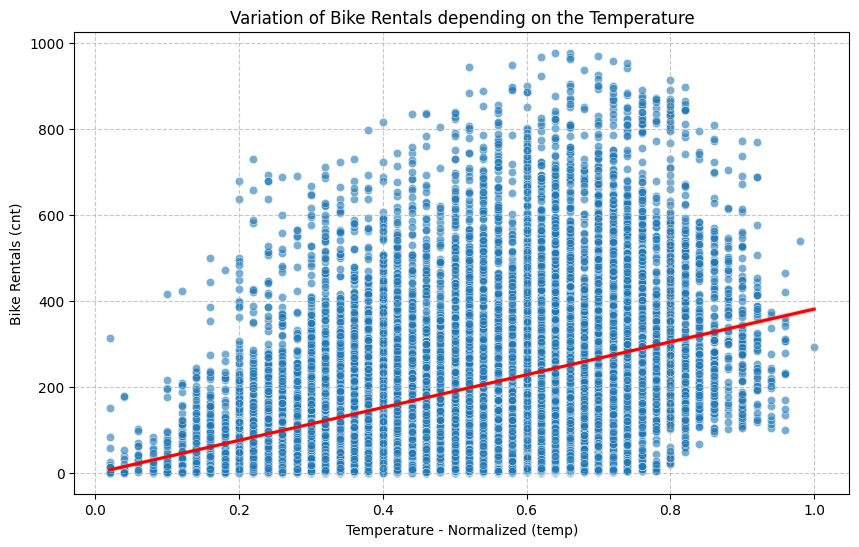

In [11]:
# Graph that shows the Bike Rentals variation depending on the Temperature

plt.figure(figsize=(10, 6))
sns.scatterplot(x='temp', y='cnt', data=df, alpha=0.6)
sns.regplot(x='temp', y='cnt', data=df, scatter=False, color='red') # add a regression line
plt.title('Variation of Bike Rentals depending on the Temperature')
plt.xlabel('Temperature - Normalized (temp)')
plt.ylabel('Bike Rentals (cnt)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()


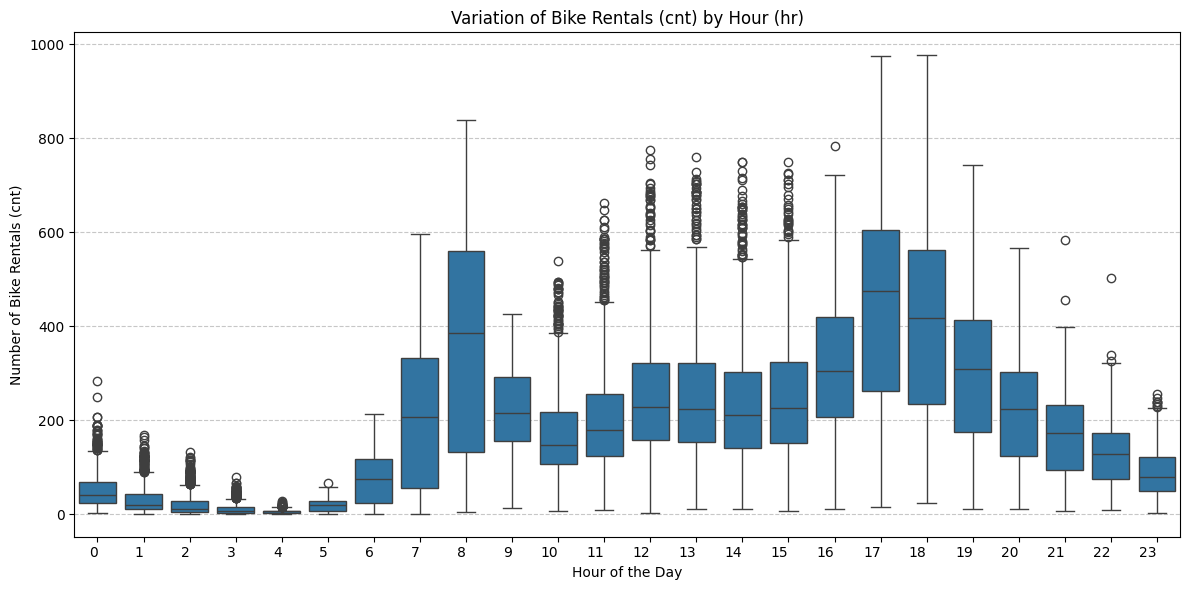

In [12]:
# Graphic that shos the variation of Bike Rentals depending on the Hours

plt.figure(figsize=(12, 6))
sns.boxplot(x='hr', y='cnt', data=df)
plt.title('Variation of Bike Rentals (cnt) by Hour (hr)')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Bike Rentals (cnt)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(ha='right')
plt.tight_layout()
plt.show()


#### Analysis

From a first appoach, the data shows expected results in terms of amount of Bike rentals during the less / more active hours. And a clearer higher amount of rentals when the wheather and temperature are clearer or higher.
The higher number of rentals in the summer and autumn only double checks what was expected and his confirmed on the above graphics.

It is important to mention the 7-9H and the 16-19H peaks, probably corresponding to the people going to work, or addressing a early or late afternoon exercise routine.

# Phase 3

##Model(s) Selection

Our "Target" metric - the one we want to test if we can successfully preduct - is "cnt" - count of total rental bikes including both casual and registered.

The models will "try" to understand what are the variables that majorly contribute to the reason why the bike it is not rented.

The first approach will be to understand what kind of variables conntribute to this value, note that because "casual" and "registered" are the values that sum up to "cnt" this values will not be interpreted.

### Variables importance to CNT

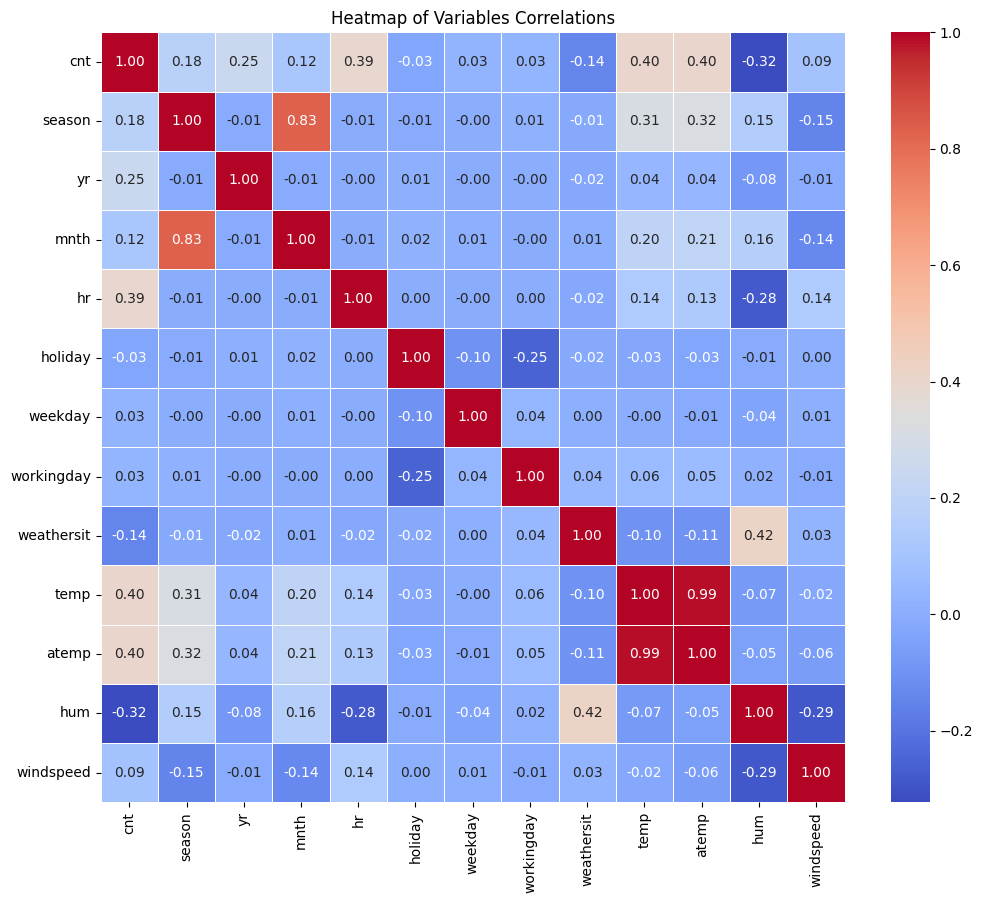

In [13]:
# Create an heatmap with selected variables

df_heatmap = df[
    ['cnt', 'season', 'yr', 'mnth', 'hr', 'holiday', 'weekday',
     'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed']].copy()

corr_matrix = df_heatmap.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Heatmap of Variables Correlations')
plt.show()

From the heatmap we can clearly see that 2 variables are almost perfectly aligned - the temperature and the feeled temperature.

Therefor, it is important to drop one, in order to maintain a better prediction for the model.

In [14]:
# create a copy of the dataset, that we will make changes to, in order to maintaing the original, inaltered

br = df.copy()

In [15]:
# drop the first variables that don't add information, or that the information is repeated

br = br.drop(['casual', 'registered', 'instant', 'dteday', 'calculated_cnt', 'yr'], axis=1)

In [16]:
# RMSE
# I want to know (in numbers) what features more conntribute to cnt
# Note that we still haven't dropped "temp" or "atemp", because we still don't know what is the less important

# NOTE: we are using the RMSE to interpret the results, because,
# for regressions (as is the case), we interpret it as the best

print('RMSE means: Root Mean Squared Error')
print('It measures the number of errors elevated by 2')
print('This means, that lower the number > the better\n')

X = br[['season', 'holiday', 'weekday', 'workingday', 'weathersit']]  # Categorical variables
y = br['cnt']

# Measure categorical variables
results = {}
for col in X.columns:
    pipe = Pipeline([('ohe', OneHotEncoder(drop='first', sparse_output=False)),
                     ('rf', RandomForestRegressor(n_estimators=50, random_state=42))])
    cv_rmse = -cross_val_score(pipe, df[[col]], y, cv=5, scoring='neg_root_mean_squared_error')
    results[col] = cv_rmse.mean()
    print(f'{col}: RMSE {cv_rmse.mean():.3f}')

best_cat = min(results, key=results.get)

# Measure numerical variables
num_cols = ['hr', 'temp', 'atemp', 'hum', 'windspeed']
for col in num_cols:
    rf = RandomForestRegressor(n_estimators=50, random_state=42)
    cv_rmse = -cross_val_score(rf, df[[col]], y, cv=5, scoring='neg_root_mean_squared_error')
    print(f'{col}: RMSE {cv_rmse.mean():.3f}')


RMSE means: Root Mean Squared Error
It measures the number of errors elevated by 2
This means, that lower the number > the better

season: RMSE 183.188
holiday: RMSE 182.144
weekday: RMSE 182.191
workingday: RMSE 182.164
weathersit: RMSE 180.287
hr: RMSE 136.005
temp: RMSE 167.531
atemp: RMSE 166.165
hum: RMSE 176.339
windspeed: RMSE 181.993


From our results, we can interpret the most important variables are the following (by order):
* hr (N)
* atemp (N)
* temp (N)
* hum (N)
* weathersit (C)
* windspeed (N)
* holiday (C)
* workingday (C)
* weekday (C)
* season (C)


In [17]:
# Assuming "Hour" and "Sented Temperature" as our principal features, we want to see how the rest contribute

y = br['cnt']
base = ['hr', 'atemp']
base_rmse = -cross_val_score(RandomForestRegressor(n_estimators=50,random_state=42), br[base], y, cv=5).mean()
print('Base hr + atemp:', base_rmse)

candidates = ['weathersit', 'season', 'workingday', 'temp', 'hum', 'windspeed', 'mnth', 'holiday', 'weekday']
for cand in candidates:
    feats = base + [cand]
    rmse = -cross_val_score(RandomForestRegressor(n_estimators=50,random_state=42), br[feats], y, cv=5).mean()
    delta = rmse - base_rmse
    print(f'+{cand}: RMSE {rmse:.1f} (delta {delta:+.1f})')


Base hr + atemp: -0.401299074194447
+weathersit: RMSE -0.4 (delta +0.0)
+season: RMSE -0.2 (delta +0.2)
+workingday: RMSE -0.5 (delta -0.1)
+temp: RMSE -0.4 (delta +0.0)
+hum: RMSE -0.3 (delta +0.1)
+windspeed: RMSE -0.3 (delta +0.1)
+mnth: RMSE -0.1 (delta +0.3)
+holiday: RMSE -0.4 (delta +0.0)
+weekday: RMSE -0.5 (delta -0.1)


In [18]:
# Now we will test different models in order to understand what are the ones that offer best results
# Note that we are still using all variables

y = br['cnt']
X = br[['season', 'mnth', 'hr', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed']]

cat_cols = ['season', 'mnth', 'hr', 'weekday', 'weathersit']
num_cols = ['holiday', 'workingday', 'temp', 'atemp', 'hum', 'windspeed']
preproc = ColumnTransformer([('num', StandardScaler(), num_cols), ('cat', OneHotEncoder(drop='first', sparse_output=False), cat_cols)])

print('LinearRegression')
lr_pipe = Pipeline([('pre', preproc), ('model', LinearRegression())])
lr_cv = -cross_val_score(lr_pipe, X, y, cv=5, scoring='neg_root_mean_squared_error')
print('5 CVs:', lr_cv)
print('Média:', lr_cv.mean().round(1), 'Std:', lr_cv.std().round(1))

print('\nRidge')
ridge_pipe = Pipeline([('pre', preproc), ('model', Ridge())])
ridge_cv = -cross_val_score(ridge_pipe, X, y, cv=5, scoring='neg_root_mean_squared_error')
print('5 CVs:', ridge_cv)
print('Média:', ridge_cv.mean().round(1), 'Std:', ridge_cv.std().round(1))

print('\nLasso')
lasso_pipe = Pipeline([('pre', preproc), ('model', Lasso())])
lasso_cv = -cross_val_score(lasso_pipe, X, y, cv=5, scoring='neg_root_mean_squared_error')
print('5 CVs:', lasso_cv)
print('Média:', lasso_cv.mean().round(1), 'Std:', lasso_cv.std().round(1))

print('\nDecisionTree')
dt_pipe = Pipeline([('pre', preproc), ('model', DecisionTreeRegressor(random_state=42, max_depth=10))])
dt_cv = -cross_val_score(dt_pipe, X, y, cv=5, scoring='neg_root_mean_squared_error')
print('5 CVs:', dt_cv)
print('Média:', dt_cv.mean().round(1), 'Std:', dt_cv.std().round(1))

print('\nRandomForest')
rf_pipe = Pipeline([('pre', preproc), ('model', RandomForestRegressor(n_estimators=50, random_state=42))])
rf_cv = -cross_val_score(rf_pipe, X, y, cv=5, scoring='neg_root_mean_squared_error')
print('5 CVs:', rf_cv)
print('Média:', rf_cv.mean().round(1), 'Std:', rf_cv.std().round(1))

print('\nGradientBoosting')
gb_pipe = Pipeline([('pre', preproc), ('model', GradientBoostingRegressor(n_estimators=50, random_state=42))])
gb_cv = -cross_val_score(gb_pipe, X, y, cv=5, scoring='neg_root_mean_squared_error')
print('5 CVs:', gb_cv)
print('Média:', gb_cv.mean().round(1), 'Std:', gb_cv.std().round(1))


LinearRegression
5 CVs: [125.72865044 126.55652026 107.30839841 153.14465141 158.45281013]
Média: 134.2 Std: 19.0

Ridge
5 CVs: [125.36792343 126.49924185 107.05590991 153.25445337 158.54141183]
Média: 134.1 Std: 19.1

Lasso
5 CVs: [108.18901344 125.66387993  94.86263134 158.4558612  169.28386765]
Média: 131.3 Std: 28.5

DecisionTree
5 CVs: [112.38183187 139.18012408 107.14932518 150.93481202 151.75228512]
Média: 132.3 Std: 19.0

RandomForest
5 CVs: [100.30831384 115.39994195  88.14480062 125.50465567 124.20168333]
Média: 110.7 Std: 14.4

GradientBoosting
5 CVs: [ 96.98822958 109.52985292  83.11917991 153.79465317 163.56767143]
Média: 121.4 Std: 31.7


1 feats (adiciona hr): RMSE 142.3, R² 0.38
2 feats (adiciona temp): RMSE 126.6, R² 0.51
3 feats (adiciona mnth): RMSE 151.0, R² 0.31
4 feats (adiciona season): RMSE 150.5, R² 0.31
5 feats (adiciona workingday): RMSE 130.3, R² 0.48
6 feats (adiciona hum): RMSE 120.2, R² 0.56
7 feats (adiciona windspeed): RMSE 118.5, R² 0.57
8 feats (adiciona weathersit): RMSE 117.4, R² 0.58
9 feats (adiciona atemp): RMSE 117.5, R² 0.58
10 feats (adiciona holiday): RMSE 117.3, R² 0.58
11 feats (adiciona weekday): RMSE 116.5, R² 0.59


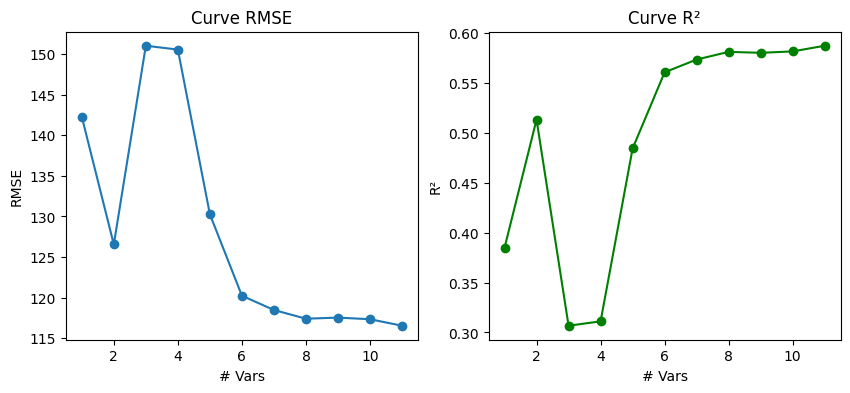

In [19]:
# We nok want to check how many variables are the ideal to predict the "cnt"
# We will use the order previously analised

y = br['cnt']
feature_order = ['hr', 'temp', 'mnth', 'season', 'workingday', 'hum', 'windspeed',  'weathersit', 'atemp', 'holiday', 'weekday']
X = br[feature_order]

rmses = []; r2s = []; baseline = y.std()

for n in range(1, len(feature_order)+1):
    top_n = feature_order[:n]
    cat = [f for f in top_n if f in ['season', 'weathersit', 'mnth', 'weekday']]
    num = [f for f in top_n if f not in cat]
    preproc = ColumnTransformer([('num', StandardScaler(), num), ('cat', OneHotEncoder(drop='first', sparse_output=False), cat)])
    rf_pipe = Pipeline([('pre', preproc), ('rf', RandomForestRegressor(n_estimators=30, random_state=42))])
    rmse = -cross_val_score(rf_pipe, df[top_n], y, cv=3, scoring='neg_root_mean_squared_error').mean()
    r2 = 1 - (rmse/baseline)**2
    rmses.append(rmse); r2s.append(r2)
    print(f'{n} feats (adiciona {top_n[-1]}): RMSE {rmse:.1f}, R² {r2:.2f}')

# Graphic
plt.figure(figsize=(10,4))
plt.subplot(121); plt.plot(range(1,len(rmses)+1), rmses, marker='o'); plt.xlabel('# Vars'); plt.ylabel('RMSE'); plt.title('Curve RMSE')
plt.subplot(122); plt.plot(range(1,len(r2s)+1), r2s, marker='o', color='g'); plt.xlabel('# Vars'); plt.ylabel('R²'); plt.title('Curve R²')
plt.show()


1 feats (adiciona hr): RMSE 142.3, R² 0.38
2 feats (adiciona temp): RMSE 126.6, R² 0.51
3 feats (adiciona workingday): RMSE 110.4, R² 0.63
4 feats (adiciona hum): RMSE 110.4, R² 0.63
5 feats (adiciona windspeed): RMSE 106.0, R² 0.66
6 feats (adiciona weathersit): RMSE 104.8, R² 0.67
7 feats (adiciona weekday): RMSE 102.5, R² 0.68
8 feats (adiciona holiday): RMSE 102.5, R² 0.68
9 feats (adiciona atemp): RMSE 102.8, R² 0.68
10 feats (adiciona mnth): RMSE 116.5, R² 0.59
11 feats (adiciona season): RMSE 116.3, R² 0.59


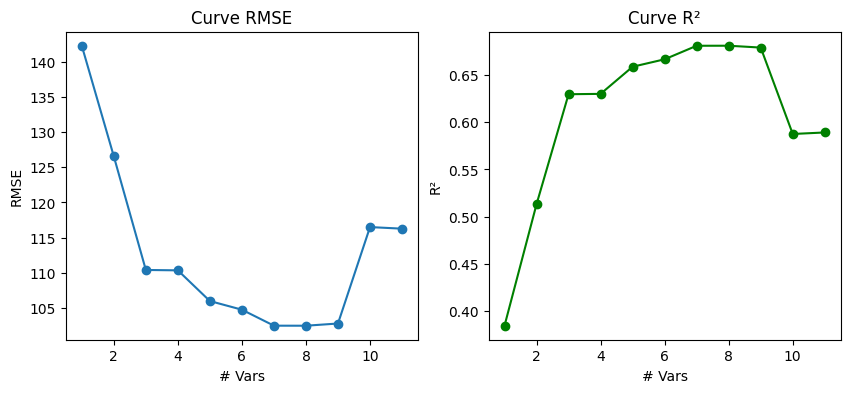

In [20]:
# It was curious to see that "mnth" and "season" althought with good results in previous tests
# in the last, seemed to increase the complexity and "confuse" the program - this one tests the same, but with the variables being testes in last

y = br['cnt']
feature_order = ['hr', 'temp', 'workingday', 'hum', 'windspeed',  'weathersit', 'weekday', 'holiday', 'atemp',   'mnth', 'season']
X = br[feature_order]

rmses = []; r2s = []; baseline = y.std()

for n in range(1, len(feature_order)+1):
    top_n = feature_order[:n]
    cat = [f for f in top_n if f in ['season', 'weathersit', 'mnth', 'weekday']]
    num = [f for f in top_n if f not in cat]
    preproc = ColumnTransformer([('num', StandardScaler(), num), ('cat', OneHotEncoder(drop='first', sparse_output=False), cat)])
    rf_pipe = Pipeline([('pre', preproc), ('rf', RandomForestRegressor(n_estimators=30, random_state=42))])
    rmse = -cross_val_score(rf_pipe, df[top_n], y, cv=3, scoring='neg_root_mean_squared_error').mean()
    r2 = 1 - (rmse/baseline)**2
    rmses.append(rmse); r2s.append(r2)
    print(f'{n} feats (adiciona {top_n[-1]}): RMSE {rmse:.1f}, R² {r2:.2f}')

# Graphic
plt.figure(figsize=(10,4))
plt.subplot(121); plt.plot(range(1,len(rmses)+1), rmses, marker='o'); plt.xlabel('# Vars'); plt.ylabel('RMSE'); plt.title('Curve RMSE')
plt.subplot(122); plt.plot(range(1,len(r2s)+1), r2s, marker='o', color='g'); plt.xlabel('# Vars'); plt.ylabel('R²'); plt.title('Curve R²')
plt.show()


In [21]:
# Having in mind that 7 features could already predict with a relatively high precision the "cnt",
# we adapted the prvious code to see with only the selected variables

y = br['cnt']
X = br[['hr', 'temp', 'workingday', 'hum', 'windspeed',  'weathersit', 'weekday']]

cat_cols = ['hr', 'workingday', 'weathersit', 'weekday']
num_cols = ['temp', 'hum', 'windspeed']
preproc = ColumnTransformer([('num', StandardScaler(), num_cols), ('cat', OneHotEncoder(drop='first', sparse_output=False), cat_cols)])

print('LinearRegression')
lr_pipe = Pipeline([('pre', preproc), ('model', LinearRegression())])
lr_cv = -cross_val_score(lr_pipe, X, y, cv=5, scoring='neg_root_mean_squared_error')
print('5 CVs:', lr_cv)
print('Média:', lr_cv.mean().round(1), 'Std:', lr_cv.std().round(1))

print('\nRidge')
ridge_pipe = Pipeline([('pre', preproc), ('model', Ridge())])
ridge_cv = -cross_val_score(ridge_pipe, X, y, cv=5, scoring='neg_root_mean_squared_error')
print('5 CVs:', ridge_cv)
print('Média:', ridge_cv.mean().round(1), 'Std:', ridge_cv.std().round(1))

print('\nLasso')
lasso_pipe = Pipeline([('pre', preproc), ('model', Lasso())])
lasso_cv = -cross_val_score(lasso_pipe, X, y, cv=5, scoring='neg_root_mean_squared_error')
print('5 CVs:', lasso_cv)
print('Média:', lasso_cv.mean().round(1), 'Std:', lasso_cv.std().round(1))

print('\nDecisionTree')
dt_pipe = Pipeline([('pre', preproc), ('model', DecisionTreeRegressor(random_state=42, max_depth=10))])
dt_cv = -cross_val_score(dt_pipe, X, y, cv=5, scoring='neg_root_mean_squared_error')
print('5 CVs:', dt_cv)
print('Média:', dt_cv.mean().round(1), 'Std:', dt_cv.std().round(1))

print('\nRandomForest')
rf_pipe = Pipeline([('pre', preproc), ('model', RandomForestRegressor(n_estimators=50, random_state=42))])
rf_cv = -cross_val_score(rf_pipe, X, y, cv=5, scoring='neg_root_mean_squared_error')
print('5 CVs:', rf_cv)
print('Média:', rf_cv.mean().round(1), 'Std:', rf_cv.std().round(1))

print('\nGradientBoosting')
gb_pipe = Pipeline([('pre', preproc), ('model', GradientBoostingRegressor(n_estimators=50, random_state=42))])
gb_cv = -cross_val_score(gb_pipe, X, y, cv=5, scoring='neg_root_mean_squared_error')
print('5 CVs:', gb_cv)
print('Média:', gb_cv.mean().round(1), 'Std:', gb_cv.std().round(1))


LinearRegression
5 CVs: [121.52539436 123.98065019  86.52316464 139.00573845 156.40495203]
Média: 125.5 Std: 23.1

Ridge
5 CVs: [121.25315955 123.99498259  86.29890979 139.13637932 156.54402471]
Média: 125.4 Std: 23.3

Lasso
5 CVs: [112.4175568  128.05207297  84.23077735 149.84358256 168.03405129]
Média: 128.5 Std: 29.1

DecisionTree
5 CVs: [112.24974418 126.5474817   90.18302097 132.63193611 147.3195625 ]
Média: 121.8 Std: 19.4

RandomForest
5 CVs: [102.82729945 104.19535262  69.7676888   96.50348461 116.27997739]
Média: 97.9 Std: 15.5

GradientBoosting
5 CVs: [ 98.8476935  107.2784324   73.53195638 143.4204621  161.46234382]
Média: 116.9 Std: 31.6


### Analysis

Comparing the averages

All variables:
LinearRegression
Média: 134.2 Std: 19.0

Ridge
Média: 134.1 Std: 19.1

Lasso
Média: 131.3 Std: 28.5

DecisionTree
Média: 132.3 Std: 19.0

RandomForest
Média: 110.7 Std: 14.4

GradientBoosting
Média: 121.4 Std: 31.7




---


Selected variables:
LinearRegression
Média: 125.5 Std: 23.1

Ridge
Média: 125.4 Std: 23.3

Lasso
Média: 128.5 Std: 29.1

DecisionTree
Média: 121.8 Std: 19.4

RandomForest
Média: 97.9 Std: 15.5

GradientBoosting
Média: 116.9 Std: 31.6


We can see that in the majority of the models, there was an increase in the quality of the prediction when using only 6 variables.

The best model in both tests was the Random Forest

# Phase 4

In the phase 4 - Implementation & Experimentation, we intend to use the Random Forest model to predict our target variable - cnt.



The Random Forest is a model where we have several decision trees analysing the previous data and making an estimaded guess on the "cnt" value. Delivering after the mean of all the results.

## Implementation of the Random Forest model - 7 variables

In [22]:
# We begin by setting the number of trees

y = br['cnt']
X = br[['hr', 'temp', 'workingday', 'hum', 'windspeed',  'weathersit', 'weekday']]

cat_cols = ['hr', 'workingday', 'weathersit', 'weekday']
num_cols = ['temp', 'hum', 'windspeed']
preproc = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(drop='first', sparse_output=False), cat_cols)
])

rf_pipe = Pipeline([
    ('preproc', preproc),
    ('rf', RandomForestRegressor(
        n_estimators=100, # number of trees
        random_state=42,  # random number to choose lines from the dataset
        max_depth=15))    # number of levels of decision
])

In [23]:
# Split into train and test
# We will use ~70% of the dataset to train and the rest to test (30%)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [24]:
# Using the trees we have already defined, the program use them to train
# NOTE that we are only training in here

rf_pipe.fit(X_train, y_train)

Pipeline(steps=[('preproc',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['temp', 'hum', 'windspeed']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                                                sparse_output=False),
                                                  ['hr', 'workingday',
                                                   'weathersit',
                                                   'weekday'])])),
                ('rf', RandomForestRegressor(max_depth=15, random_state=42))])

In [25]:
# We start to use the model to predict the "cnt"

y_pred_train = rf_pipe.predict(X_train) # Predict based on the training
y_pred_test = rf_pipe.predict(X_test)   # Predict numbers that have never "seen"

print(f'Train RMSE: {np.sqrt(mean_squared_error(y_train, y_pred_train)):.1f}')
print(f'Test RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_test)):.1f}')
print(f'Test R²: {r2_score(y_test, y_pred_test):.3f}')
print(f'CV5 RMSE: {(-cross_val_score(rf_pipe, X, y, cv=5, scoring="neg_root_mean_squared_error").mean()):.1f}')


Train RMSE: 62.5
Test RMSE: 85.4
Test R²: 0.769
CV5 RMSE: 102.3


In [26]:
# Features more relevant
importances = pd.Series(rf_pipe.named_steps['rf'].feature_importances_,
                       index=rf_pipe.named_steps['preproc'].get_feature_names_out()).sort_values(ascending=False)
print('Top Features to determine "cnt":\n', importances)

Top Features to determine "cnt":
 num__temp            0.198221
num__hum             0.172929
cat__hr_17           0.107603
cat__workingday_1    0.092687
cat__hr_18           0.077947
cat__hr_8            0.076925
cat__hr_19           0.032712
num__windspeed       0.032628
cat__hr_16           0.018360
cat__hr_2            0.015583
cat__hr_7            0.015419
cat__hr_4            0.014447
cat__hr_1            0.014446
cat__hr_3            0.014094
cat__weathersit_3    0.013784
cat__hr_5            0.012241
cat__hr_20           0.011707
cat__hr_9            0.011590
cat__hr_12           0.007066
cat__hr_13           0.005526
cat__weekday_5       0.005273
cat__hr_23           0.005190
cat__weathersit_2    0.004811
cat__weekday_1       0.004694
cat__hr_11           0.004235
cat__weekday_2       0.003892
cat__weekday_3       0.003880
cat__weekday_4       0.003832
cat__hr_10           0.003552
cat__hr_14           0.003200
cat__weekday_6       0.003120
cat__hr_6            0.002915
cat__h

In [27]:
# Model saved
joblib.dump(rf_pipe, 'rf_bike_model.pkl')
print('Modelo salvo: rf_bike_model.pkl')

Modelo salvo: rf_bike_model.pkl


## Implementation of the Random Forest model - All variables

In [28]:
# We intend to make a second model to test if with all the variables we get better results

y = br['cnt']
X = df[['season', 'yr', 'mnth', 'hr', 'holiday',
        'weekday', 'temp', 'atemp', 'workingday', 'hum', 'windspeed',  'weathersit',]]

cat_cols = ['season','yr','hr', 'mnth','workingday', 'weathersit', 'holiday', 'weekday']
num_cols = ['temp', 'hum', 'atemp', 'windspeed']
preproc = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(drop='first', sparse_output=False), cat_cols)
])

rf_pipe = Pipeline([
    ('preproc', preproc),
    ('rf', RandomForestRegressor(
        n_estimators=100, # number of trees
        random_state=42,  # random number to choose lines from the dataset
        max_depth=15))    # number of levels of decision
])


# Split into train and test
# We will use ~70% of the dataset to train and the rest to test (30%)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


# Using the trees we have already defined, the program use them to train
# NOTE that we are only training in here

rf_pipe.fit(X_train, y_train)


# We start to use the model to predict the "cnt"

y_pred_train = rf_pipe.predict(X_train) # Predict based on the training
y_pred_test = rf_pipe.predict(X_test)   # Predict numbers that have never "seen"

print(f'Train RMSE: {np.sqrt(mean_squared_error(y_train, y_pred_train)):.1f}')
print(f'Test RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_test)):.1f}')
print(f'Test R²: {r2_score(y_test, y_pred_test):.3f}')
print(f'CV5 RMSE: {(-cross_val_score(rf_pipe, X, y, cv=5, scoring="neg_root_mean_squared_error").mean()):.1f}')


# Features more relevant
importances = pd.Series(rf_pipe.named_steps['rf'].feature_importances_,
                       index=rf_pipe.named_steps['preproc'].get_feature_names_out()).sort_values(ascending=False)
print('Top Features to determine "cnt":\n', importances)


# Model saved
joblib.dump(rf_pipe, 'all_variables_model.pkl')
print('Modelo salvo: all_variables_model.pkl')


Train RMSE: 52.9
Test RMSE: 66.6
Test R²: 0.860
CV5 RMSE: 88.8
Top Features to determine "cnt":
 num__atemp           0.173085
cat__hr_17           0.108586
cat__workingday_1    0.094262
cat__yr_1            0.089526
cat__hr_18           0.081060
num__hum             0.074078
cat__hr_8            0.067492
num__temp            0.060263
cat__hr_19           0.032689
cat__hr_16           0.016453
cat__hr_4            0.015402
cat__hr_2            0.015230
cat__hr_7            0.015107
cat__season_4        0.014712
cat__hr_1            0.014197
cat__hr_3            0.013915
cat__hr_9            0.012068
cat__hr_5            0.011670
cat__weathersit_3    0.010038
cat__hr_20           0.009879
num__windspeed       0.009500
cat__hr_23           0.005520
cat__hr_12           0.004462
cat__hr_13           0.003446
cat__weekday_5       0.003164
cat__weekday_6       0.003101
cat__mnth_10         0.002917
cat__hr_6            0.002764
cat__hr_11           0.002469
cat__mnth_9          0.002311
cat

7 Variables:
* Treino RMSE: 62.5
* Teste RMSE: 85.4
* Teste R²: 0.769
* CV5 RMSE: 102.3


---
All variables:
* Train RMSE: 52.9
* Test RMSE: 66.6
* Test R²: 0.860
* CV5 RMSE: 88.8

### Analysis

Althought we intended to create a model with less variables in order to not get "distractions", at least accordingly with our tests, the model with all the variables presents a higher chance of success.

We will test both in the continuation of this project.

# Phase 5

On this phase, we want to evaluate our model.

For this we want to test "how well" can the model predict the original "cnt"

## 7 Variables model

In [29]:
# testing with the original dataset

modelo = joblib.load('rf_bike_model.pkl')

features = ['hr', 'temp', 'workingday', 'hum', 'windspeed',  'weathersit', 'weekday']

X = br[features]
y_true = df['cnt']

# Prediction on all dataset
y_pred = modelo.predict(X)

# Principal evaluation metrics
rmse = np.sqrt(mean_squared_error(y_true, y_pred)) # Corrected: Calculate RMSE by taking the square root of MSE
r2 = r2_score(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)

print(f"Dataset shape: {br.shape}")
print(f"RMSE original: {rmse:.2f} (mean error bikes)")
print(f"R² original: {r2:.3f} (explain {r2*100:.1f}% variation)")
print(f"MAE original: {mae:.2f}")
print(f"Reak mean cnt: {y_true.mean():.1f}")

Dataset shape: (17379, 12)
RMSE original: 70.15 (mean error bikes)
R² original: 0.850 (explain 85.0% variation)
MAE original: 49.01
Reak mean cnt: 189.5


Certos vs Errados por Categoria:
certo    False  True  % Certo
cnt_cat                      
Baixo     1417  3459     70.9
Médio     2326  3582     60.6
Alto      1800  4795     72.7


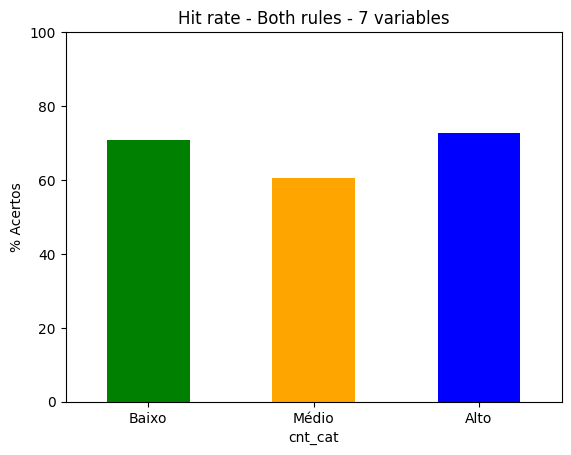


Total Acertos: 68.1%


In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Re-create br_with_pred for the 7-variable model's analysis
# Assuming 'br' and 'y_pred' (from cell DfY2RIVoA_fd) are available in the kernel state
br_with_pred = br.copy()
br_with_pred['pred'] = y_pred # y_pred should be from the 7-variable model evaluation in DfY2RIVoA_fd
br_with_pred['cnt'] = y_true # Ensure 'cnt' (y_true from DfY2RIVoA_fd) is also in br_with_pred

br_with_pred['erro_abs'] = abs(br_with_pred['pred'] - br_with_pred['cnt'])
br_with_pred['erro_pct'] = br_with_pred['erro_abs'] / br_with_pred['cnt'] * 100  # Evita /0 com filtro

# Definição: "Certo" se erro <20% ou <30 bikes abs
br_with_pred['certo'] = (br_with_pred['erro_pct'] < 20) | (br_with_pred['erro_abs'] < 30)
br_with_pred['cnt_cat'] = pd.cut(br_with_pred['cnt'], bins=[0,50,200,1000], labels=['Baixo','Médio','Alto'])

# Tabela resumo - Adicionado observed=False para resolver o FutureWarning
resumo = br_with_pred.groupby(['cnt_cat', 'certo'], observed=False).size().unstack(fill_value=0)
resumo['% Certo'] = resumo[True] / (resumo[True] + resumo[False]) * 100
print("Certos vs Errados por Categoria:")
print(resumo.round(1))

# Gráfico barras
resumo['% Certo'].plot(kind='bar', color=['green','orange','blue'])
plt.title('Hit rate - Both rules - 7 variables')
plt.ylabel('% Acertos'); plt.ylim(0,100)
plt.xticks(rotation=0)
plt.show()

print(f"\nTotal Acertos: {br_with_pred['certo'].mean()*100:.1f}%")

### Analysis

When compared the prediction to the original values, we see an overall good performance, with the model predicting well in 60.3% of the situations (having in mind our error range).

The error range is fairly more simpathetic with the "Low Movement" moments, that the "<30" helps to get more rights than wrongs in that cases.

correct vs Wrong by Category:
correct          False  True  % correct
cnt_cat                                
Low Movement      4376   500       10.3
Medium Movement   2944  2964       50.2
High Movement     1800  4795       72.7


/tmp/ipython-input-3551320822.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  resumo = br_with_pred.groupby(['cnt_cat', 'correct']).size().unstack(fill_value=0)


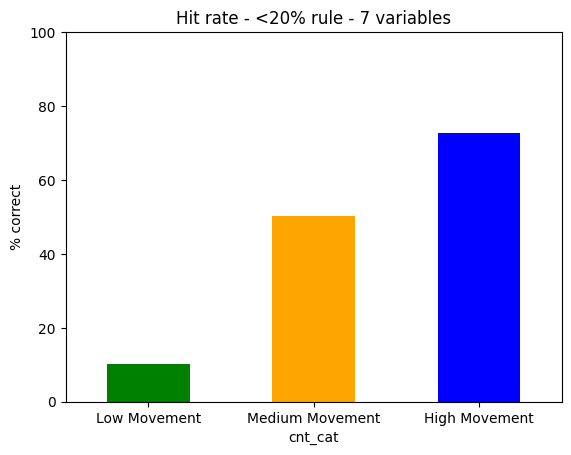


Total corrects: 47.5%


In [40]:
# Same mechanics but with error range different
# Only accepting a 20% difference

br_with_pred['erro_abs'] = abs(br_with_pred['pred'] - br_with_pred['cnt'])
br_with_pred['erro_pct'] = br_with_pred['erro_abs'] / br_with_pred['cnt'] * 100


br_with_pred['correct'] = (br_with_pred['erro_pct'] < 20)


br_with_pred['cnt_cat'] = pd.cut(br_with_pred['cnt'],
                                 bins=[0,50,200,1000], labels=['Low Movement','Medium Movement','High Movement'])

resumo = br_with_pred.groupby(['cnt_cat', 'correct']).size().unstack(fill_value=0)
resumo['% correct'] = resumo[True] / (resumo[True] + resumo[False]) * 100
print("correct vs Wrong by Category:")
print(resumo.round(1))

# Gráfico barras
resumo['% correct'].plot(kind='bar', color=['green','orange','blue'])
plt.title('Hit rate - <20% rule - 7 variables')
plt.ylabel('% correct'); plt.ylim(0,100)
plt.xticks(rotation=0)
plt.show()

print(f"\nTotal corrects: {br_with_pred['correct'].mean()*100:.1f}%")


correct vs Wrong by Category:
correct          False  True  % correct
cnt_cat                                
Low Movement      1417  3459       70.9
Medium Movement   2425  3483       59.0
High Movement     3728  2867       43.5


/tmp/ipython-input-3879536226.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  resumo = br_with_pred.groupby(['cnt_cat', 'correct']).size().unstack(fill_value=0)


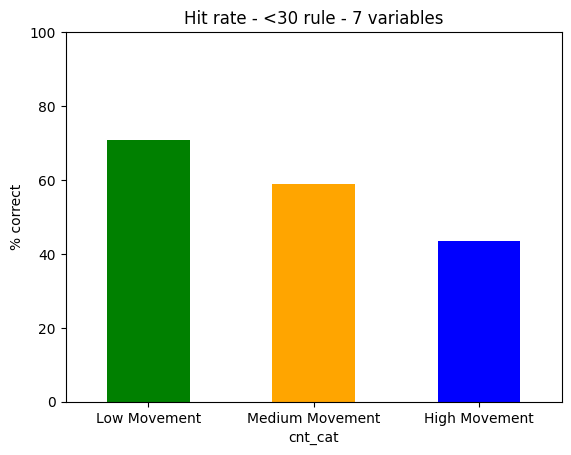


Total corrects: 56.4%


In [41]:
# Same mechanics but with error range different
# Only accepting a <30 difference

br_with_pred['erro_abs'] = abs(br_with_pred['pred'] - br_with_pred['cnt'])
br_with_pred['erro_pct'] = br_with_pred['erro_abs'] / br_with_pred['cnt'] * 100


br_with_pred['correct'] = (br_with_pred['erro_abs'] < 30)


br_with_pred['cnt_cat'] = pd.cut(br_with_pred['cnt'],
                                 bins=[0,50,200,1000], labels=['Low Movement','Medium Movement','High Movement'])

resumo = br_with_pred.groupby(['cnt_cat', 'correct']).size().unstack(fill_value=0)
resumo['% correct'] = resumo[True] / (resumo[True] + resumo[False]) * 100
print("correct vs Wrong by Category:")
print(resumo.round(1))

# Gráfico barras
resumo['% correct'].plot(kind='bar', color=['green','orange','blue'])
plt.title('Hit rate - <30 rule - 7 variables')
plt.ylabel('% correct'); plt.ylim(0,100)
plt.xticks(rotation=0)
plt.show()

print(f"\nTotal corrects: {br_with_pred['correct'].mean()*100:.1f}%")


### Analysis 2

As we mentioned earlier, the "Low Movement" moments were the harder to predict.

However still maintaining a fairly good result on the "High Movement" moments.

## All Variables model

In [33]:
# testing with the original dataset

modelo = joblib.load('all_variables_model.pkl')

features = ['season', 'yr', 'mnth', 'hr', 'holiday',
        'weekday', 'temp', 'atemp', 'workingday', 'hum', 'windspeed',  'weathersit',]

X = df[features]
y_true = df['cnt']

# Prediction on all dataset
y_pred = modelo.predict(X)

# Principal evaluation metrics
rmse = np.sqrt(mean_squared_error(y_true, y_pred)) # Corrected: Calculate RMSE by taking the square root of MSE
r2 = r2_score(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)

print(f"Dataset shape: {br.shape}")
print(f"RMSE original: {rmse:.2f} (mean error bikes)")
print(f"R² original: {r2:.3f} (explain {r2*100:.1f}% variation)")
print(f"MAE original: {mae:.2f}")
print(f"Reak mean cnt: {y_true.mean():.1f}")

Dataset shape: (17379, 12)
RMSE original: 57.34 (mean error bikes)
R² original: 0.900 (explain 90.0% variation)
MAE original: 39.00
Reak mean cnt: 189.5


RMSE original all: 57.34
R² original all: 0.900

Correct vs Wrong by Category (All Variables):
correct          False  True  % correct
cnt_cat                                
Low Movement      1417  3459       70.9
Medium Movement   2326  3582       60.6
High Movement     1800  4795       72.7


/tmp/ipython-input-2013082485.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  resumo = br_with_pred.groupby(['cnt_cat', 'correct']).size().unstack(fill_value=0)


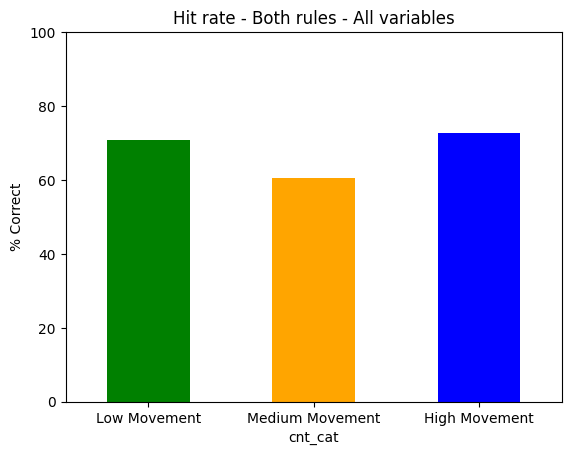


Total Corrects All Model: 68.1%


In [42]:
model_all = joblib.load('all_variables_model.pkl')

X_full = df[['season', 'yr', 'mnth', 'hr', 'holiday',
        'weekday', 'temp', 'atemp', 'workingday', 'hum', 'windspeed',  'weathersit']]
br_with_pred = br.copy()

br_with_pred['pred'] = model_all.predict(X_full)

rmse = np.sqrt(mean_squared_error(br_with_pred['cnt'], br_with_pred['pred']))
print(f"RMSE original all: {rmse:.2f}")
print(f"R² original all: {r2_score(br_with_pred['cnt'], br_with_pred['pred']):.3f}")

br_with_pred['erro_abs'] = abs(br_with_pred['pred'] - br_with_pred['cnt'])
br_with_pred['erro_pct'] = br_with_pred['erro_abs'] / br_with_pred['cnt'].replace(0,1) * 100  # Evita /0
br_with_pred['correct'] = (br_with_pred['erro_pct'] < 20) | (br_with_pred['erro_abs'] < 30)
br_with_pred['cnt_cat'] = pd.cut(br_with_pred['cnt'], bins=[0,50,200,1000],
                                 labels=['Low Movement','Medium Movement','High Movement'])

resumo = br_with_pred.groupby(['cnt_cat', 'correct']).size().unstack(fill_value=0)
resumo['% correct'] = resumo[True] / (resumo[True] + resumo[False]) * 100
print("\nCorrect vs Wrong by Category (All Variables):")
print(resumo.round(1))

resumo['% correct'].plot(kind='bar', color=['green','orange','blue'])
plt.title('Hit rate - Both rules - All variables')
plt.ylabel('% Correct'); plt.ylim(0,100)
plt.xticks(rotation=0)
plt.show()

print(f"\nTotal Corrects All Model: {br_with_pred['correct'].mean()*100:.1f}%")

RMSE original all: 57.34
R² original all: 0.900

Correct vs Wrong by Category (All Variables):
correct          False  True  % correct
cnt_cat                                
Low Movement      4376   500       10.3
Medium Movement   2944  2964       50.2
High Movement     1800  4795       72.7


/tmp/ipython-input-3283499615.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  resumo = br_with_pred.groupby(['cnt_cat', 'correct']).size().unstack(fill_value=0)


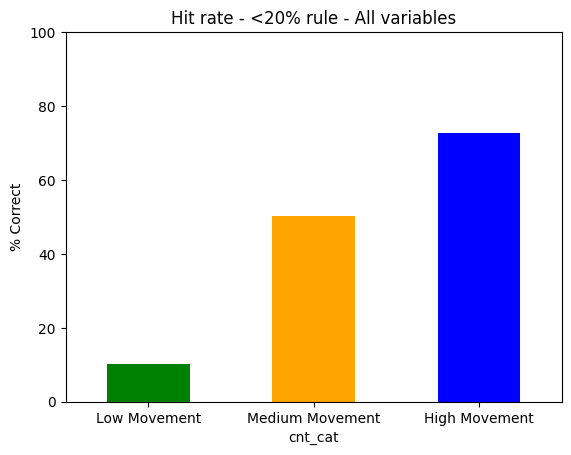


Total Corrects All Model: 47.5%


In [43]:
model_all = joblib.load('all_variables_model.pkl')

X_full = df[['season', 'yr', 'mnth', 'hr', 'holiday',
        'weekday', 'temp', 'atemp', 'workingday', 'hum', 'windspeed',  'weathersit']]
br_with_pred = br.copy()

br_with_pred['pred'] = model_all.predict(X_full)

rmse = np.sqrt(mean_squared_error(br_with_pred['cnt'], br_with_pred['pred']))
print(f"RMSE original all: {rmse:.2f}")
print(f"R² original all: {r2_score(br_with_pred['cnt'], br_with_pred['pred']):.3f}")

br_with_pred['erro_abs'] = abs(br_with_pred['pred'] - br_with_pred['cnt'])
br_with_pred['erro_pct'] = br_with_pred['erro_abs'] / br_with_pred['cnt'].replace(0,1) * 100  # Evita /0
br_with_pred['correct'] = (br_with_pred['erro_pct'] < 20)
br_with_pred['cnt_cat'] = pd.cut(br_with_pred['cnt'], bins=[0,50,200,1000],
                                 labels=['Low Movement','Medium Movement','High Movement'])

resumo = br_with_pred.groupby(['cnt_cat', 'correct']).size().unstack(fill_value=0)
resumo['% correct'] = resumo[True] / (resumo[True] + resumo[False]) * 100
print("\nCorrect vs Wrong by Category (All Variables):")
print(resumo.round(1))

resumo['% correct'].plot(kind='bar', color=['green','orange','blue'])
plt.title('Hit rate - <20% rule - All variables')
plt.ylabel('% Correct'); plt.ylim(0,100)
plt.xticks(rotation=0)
plt.show()

print(f"\nTotal Corrects All Model: {br_with_pred['correct'].mean()*100:.1f}%")

RMSE original all: 57.34
R² original all: 0.900

Correct vs Wrong by Category (All Variables):
correct          False  True  % correct
cnt_cat                                
Low Movement      1417  3459       70.9
Medium Movement   2425  3483       59.0
High Movement     3728  2867       43.5


/tmp/ipython-input-2905741113.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  resumo = br_with_pred.groupby(['cnt_cat', 'correct']).size().unstack(fill_value=0)


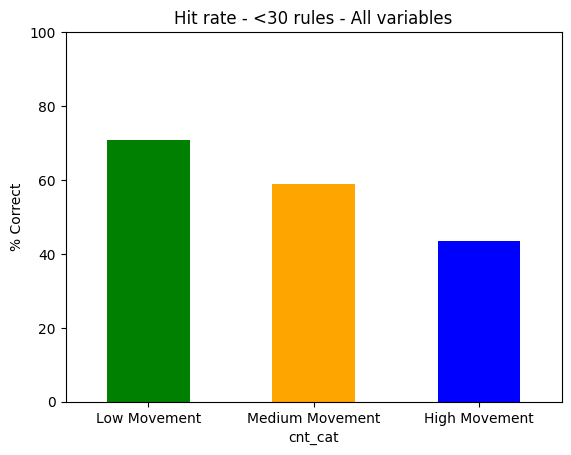


Total Corrects All Model: 56.4%


In [44]:
model_all = joblib.load('all_variables_model.pkl')

X_full = df[['season', 'yr', 'mnth', 'hr', 'holiday',
        'weekday', 'temp', 'atemp', 'workingday', 'hum', 'windspeed',  'weathersit']]
br_with_pred = br.copy()

br_with_pred['pred'] = model_all.predict(X_full)

rmse = np.sqrt(mean_squared_error(br_with_pred['cnt'], br_with_pred['pred']))
print(f"RMSE original all: {rmse:.2f}")
print(f"R² original all: {r2_score(br_with_pred['cnt'], br_with_pred['pred']):.3f}")

br_with_pred['erro_abs'] = abs(br_with_pred['pred'] - br_with_pred['cnt'])
br_with_pred['erro_pct'] = br_with_pred['erro_abs'] / br_with_pred['cnt'].replace(0,1) * 100  # Evita /0
br_with_pred['correct'] = (br_with_pred['erro_abs'] < 30)
br_with_pred['cnt_cat'] = pd.cut(br_with_pred['cnt'], bins=[0,50,200,1000],
                                 labels=['Low Movement','Medium Movement','High Movement'])

resumo = br_with_pred.groupby(['cnt_cat', 'correct']).size().unstack(fill_value=0)
resumo['% correct'] = resumo[True] / (resumo[True] + resumo[False]) * 100
print("\nCorrect vs Wrong by Category (All Variables):")
print(resumo.round(1))

resumo['% correct'].plot(kind='bar', color=['green','orange','blue'])
plt.title('Hit rate - <30 rules - All variables')
plt.ylabel('% Correct'); plt.ylim(0,100)
plt.xticks(rotation=0)
plt.show()

print(f"\nTotal Corrects All Model: {br_with_pred['correct'].mean()*100:.1f}%")

### Analysis

7 Variables vs All variables

We can clearly see overall better results on the model that uses all variables.


---

As before, in the "Low Movement" moments both models shows a lot of trouble at predicting correctly (When the error margin is only 20%). With this being the only moment when the 7 variables model gets a better result that his counterpart.




# Phase 6

With a clear "winner" model at being able to predict with almost 50% correct anwsers the number of bike rentals, the next step is to analyse how this would behave with a new set of information.

For this, we will create a fake dataset, to test our model.

In [37]:
# We create a fake and random dataset

np.random.seed(42)

hr_base_probs = [0.02]*7 + [0.08]*3 + [0.04]*6 + [0.10]*4 + [0.06]*4
hr_probs = np.array(hr_base_probs) / np.sum(hr_base_probs)

n_falso = 10000
fake_data = pd.DataFrame({
    'season': np.random.choice([1,2,3,4], n_falso, p=[0.25,0.25,0.25,0.25]),
    'yr': np.random.choice([0,1], n_falso, p=[0.4,0.6]),
    'mnth': np.random.randint(1,13, n_falso),
    'hr': np.random.choice(np.arange(24), n_falso, p=hr_probs),
    'holiday': np.random.choice([0,1], n_falso, p=[0.9,0.1]),
    'weekday': np.random.randint(0,7, n_falso),
    'workingday': np.random.choice([0,1], n_falso, p=[0.67,0.33]),
    'weathersit': np.random.choice([1,2,3,4], n_falso, p=[0.6,0.3,0.09,0.01]),
    'temp': np.round(np.clip(np.random.normal(0.50, 0.19, n_falso), 0,1), 2),
    'atemp': np.round(np.clip(np.random.normal(0.48, 0.17, n_falso), 0,1), 4),
    'hum': np.round(np.clip(np.random.normal(0.63, 0.19, n_falso), 0,1), 2),
    'windspeed': np.round(np.clip(np.random.exponential(0.19, n_falso)*0.67, 0,1), 2)
})

print("Dataset falso gerado (10000 linhas):")
print(fake_data.head())
fake_data.to_csv('fake_bike_data.csv', index=False)
print("\nSalvo: fake_bike_data.csv")

Dataset falso gerado (10000 linhas):
   season  yr  mnth  hr  holiday  weekday  workingday  weathersit  temp  \
0       2   0     6  16        1        5           0           1  0.24   
1       4   0     2  20        0        2           0           3  0.39   
2       3   0     4  19        0        2           1           1  0.57   
3       3   1     7  18        0        0           1           2  0.45   
4       1   1    11  17        0        6           0           1  0.73   

    atemp   hum  windspeed  
0  0.3952  0.51       0.00  
1  0.5891  0.38       0.07  
2  0.8090  0.33       0.53  
3  0.3388  0.71       0.66  
4  0.2163  0.10       0.19  

Salvo: fake_bike_data.csv


## Creation of fake dataset

In [38]:
# load the model intended - in this case the all variables
model_all = joblib.load('all_variables_model.pkl')

# Load the fake dataset
fake_data = pd.read_csv('fake_bike_data.csv')

# Do the prediction
fake_pred = model_all.predict(fake_data)

print(pd.DataFrame({'Prediction of Rented Bikes': np.round(fake_pred[:10]).astype(int)}))

print("Example input/pred:")
print(fake_data.iloc[0].to_dict())
print(f"Prediction for the example: {fake_pred[0]:.0f} bikes")


   Prediction of Rented Bikes
0                          51
1                         253
2                         309
3                         431
4                         395
5                         216
6                         372
7                         335
8                         449
9                         652
Example input/pred:
{'season': 2.0, 'yr': 0.0, 'mnth': 6.0, 'hr': 16.0, 'holiday': 1.0, 'weekday': 5.0, 'workingday': 0.0, 'weathersit': 1.0, 'temp': 0.24, 'atemp': 0.3952, 'hum': 0.51, 'windspeed': 0.0}
Prediction for the example: 51 bikes


# Other

After completing the majority of the project, I notived that even if the project presented no nulls, it still showed "outliers" - numbers that are "far away" from the norm.

The previous models might "read" the oputliers as normal numbers, and therefor, have more troubles in understanding and predict results.

## Removal of outliers

In [63]:
clean_df = df.copy()

In [65]:
outlier_indices_season = []

for season in clean_df['season'].unique():
    season_df = clean_df[clean_df['season'] == season]

    Q1 = season_df['cnt'].quantile(0.25)
    Q3 = season_df['cnt'].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = season_df[(season_df['cnt'] < lower_bound) | (season_df['cnt'] > upper_bound)]
    outlier_indices_season.extend(outliers.index.tolist())

print(f"Total de outliers de 'cnt' identificados por esta\u00e7\u00e3o: {len(set(outlier_indices_season))}")

Total de outliers de 'cnt' identificados por estação: 478


In [71]:
# Create a copy of clean_df before outlier removal for comparison
clean_df_before_removal = clean_df.copy()

# Remove outliers directly from clean_df
clean_df = clean_df.drop(outlier_indices_season)

print(f"Shape of clean_df after outlier removal: {clean_df.shape}")

# Calculate the number of removed rows
num_original_rows = clean_df_before_removal.shape[0]
num_rows_after_removal = clean_df.shape[0]
num_removed_rows = num_original_rows - num_rows_after_removal

print(f"Number of rows removed: {num_removed_rows}")

Shape of clean_df after outlier removal: (16901, 18)
Number of rows removed: 478


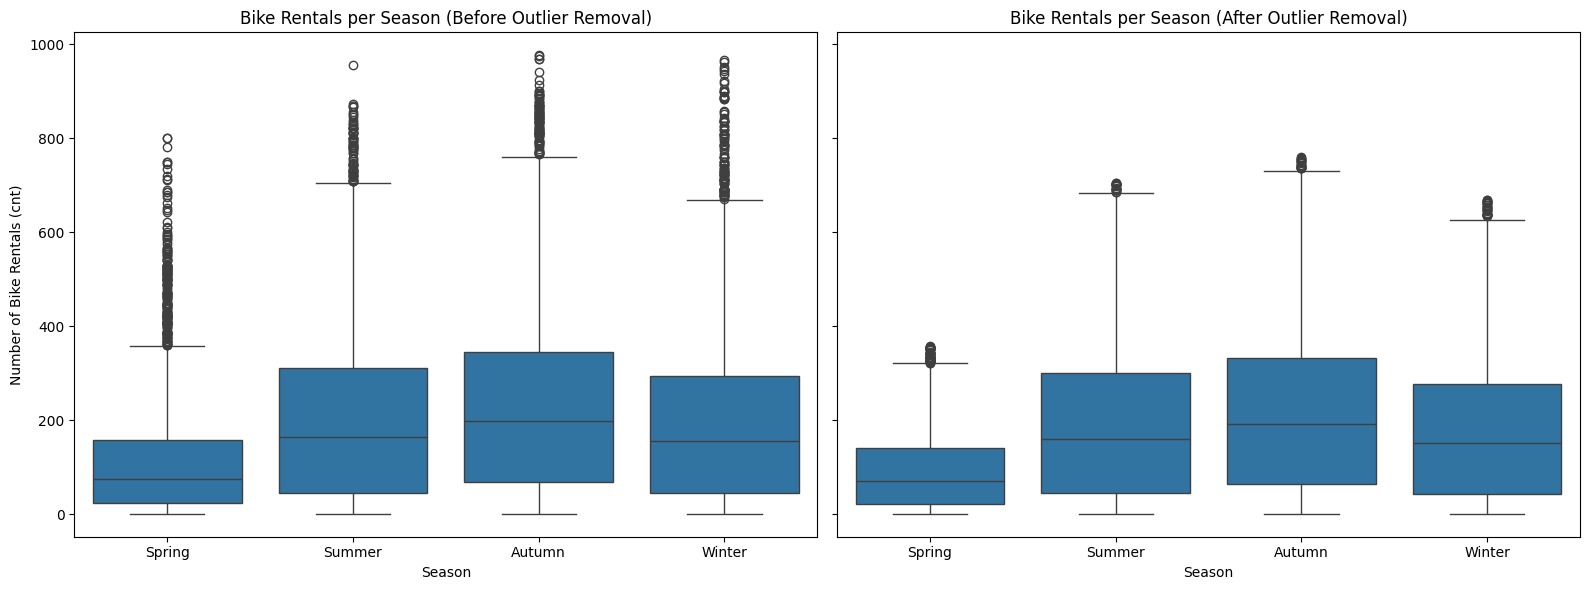

In [72]:
# Create a figure with two subplots side-by-side
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

# Boxplot for data BEFORE outlier removal
sns.boxplot(x='season', y='cnt', data=clean_df_before_removal, ax=axes[0])
axes[0].set_title('Bike Rentals per Season (Before Outlier Removal)')
axes[0].set_xlabel('Season')
axes[0].set_ylabel('Number of Bike Rentals (cnt)')
# Explicitly set ticks before labels to avoid UserWarning
axes[0].set_xticks(ticks=[0, 1, 2, 3])
axes[0].set_xticklabels(['Spring', 'Summer', 'Autumn', 'Winter'])

# Boxplot for data AFTER outlier removal
sns.boxplot(x='season', y='cnt', data=clean_df, ax=axes[1])
axes[1].set_title('Bike Rentals per Season (After Outlier Removal)')
axes[1].set_xlabel('Season')
axes[1].set_ylabel('Number of Bike Rentals (cnt)')
# Explicitly set ticks before labels to avoid UserWarning
axes[1].set_xticks(ticks=[0, 1, 2, 3])
axes[1].set_xticklabels(['Spring', 'Summer', 'Autumn', 'Winter'])

plt.tight_layout()
plt.show()

In [76]:
outlier_indices_weekday = []

for weekday in clean_df['weekday'].unique():
    weekday_df = clean_df[clean_df['weekday'] == weekday]

    Q1 = weekday_df['cnt'].quantile(0.25)
    Q3 = weekday_df['cnt'].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = weekday_df[(weekday_df['cnt'] < lower_bound) | (weekday_df['cnt'] > upper_bound)]
    outlier_indices_weekday.extend(outliers.index.tolist())

outlier_indices_weekday_unique = list(set(outlier_indices_weekday))

print(f"Total de outliers de 'cnt' identificados por dia da semana: {len(outlier_indices_weekday_unique)}")

Total de outliers de 'cnt' identificados por dia da semana: 312


Shape of clean_df after weekday outlier removal: (16589, 18)
Number of rows removed (weekday specific): 312


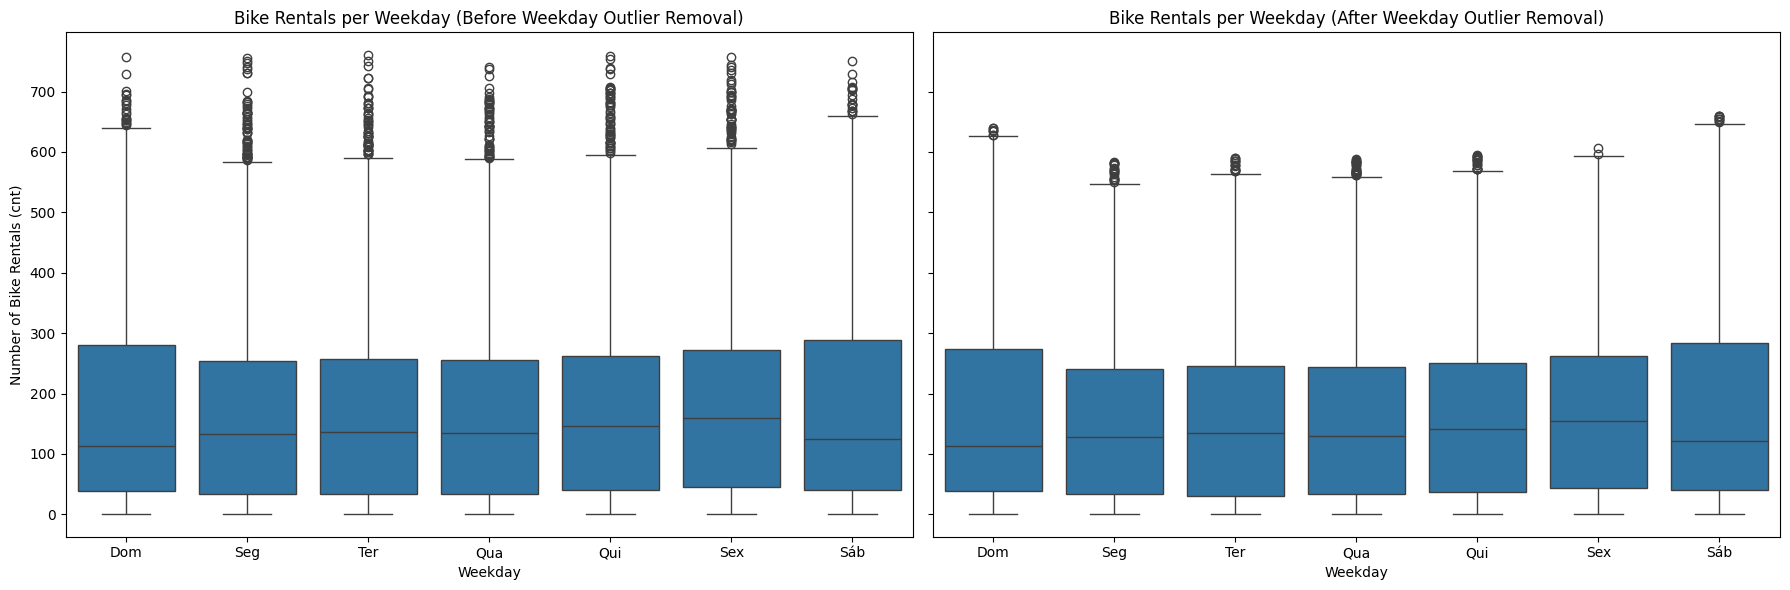

In [77]:
clean_df_before_weekday_removal = clean_df.copy()

clean_df = clean_df.drop(outlier_indices_weekday_unique)

print(f"Shape of clean_df after weekday outlier removal: {clean_df.shape}")

num_original_rows = clean_df_before_weekday_removal.shape[0]
num_rows_after_removal = clean_df.shape[0]
num_removed_rows = num_original_rows - num_rows_after_removal

print(f"Number of rows removed (weekday specific): {num_removed_rows}")

fig, axes = plt.subplots(1, 2, figsize=(18, 6), sharey=True)

sns.boxplot(x='weekday', y='cnt', data=clean_df_before_weekday_removal, ax=axes[0])
axes[0].set_title('Bike Rentals per Weekday (Before Weekday Outlier Removal)')
axes[0].set_xlabel('Weekday')
axes[0].set_ylabel('Number of Bike Rentals (cnt)')
axes[0].set_xticks(ticks=[0, 1, 2, 3, 4, 5, 6])
axes[0].set_xticklabels(['Dom', 'Seg', 'Ter', 'Qua', 'Qui', 'Sex', 'Sáb'])

sns.boxplot(x='weekday', y='cnt', data=clean_df, ax=axes[1])
axes[1].set_title('Bike Rentals per Weekday (After Weekday Outlier Removal)')
axes[1].set_xlabel('Weekday')
axes[1].set_ylabel('Number of Bike Rentals (cnt)')
axes[1].set_xticks(ticks=[0, 1, 2, 3, 4, 5, 6])
axes[1].set_xticklabels(['Dom', 'Seg', 'Ter', 'Qua', 'Qui', 'Sex', 'Sáb'])

plt.tight_layout()
plt.show()


In [78]:
outlier_indices_hr = []

for hr in clean_df['hr'].unique():
    hr_df = clean_df[clean_df['hr'] == hr]

    Q1 = hr_df['cnt'].quantile(0.25)
    Q3 = hr_df['cnt'].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = hr_df[(hr_df['cnt'] < lower_bound) | (hr_df['cnt'] > upper_bound)]
    outlier_indices_hr.extend(outliers.index.tolist())

outlier_indices_hr_unique = list(set(outlier_indices_hr))

print(f"Total de outliers de 'cnt' identificados por hora: {len(outlier_indices_hr_unique)}")

Total de outliers de 'cnt' identificados por hora: 494


Shape of clean_df after hourly outlier removal: (16095, 18)
Number of rows removed (hourly specific): 494


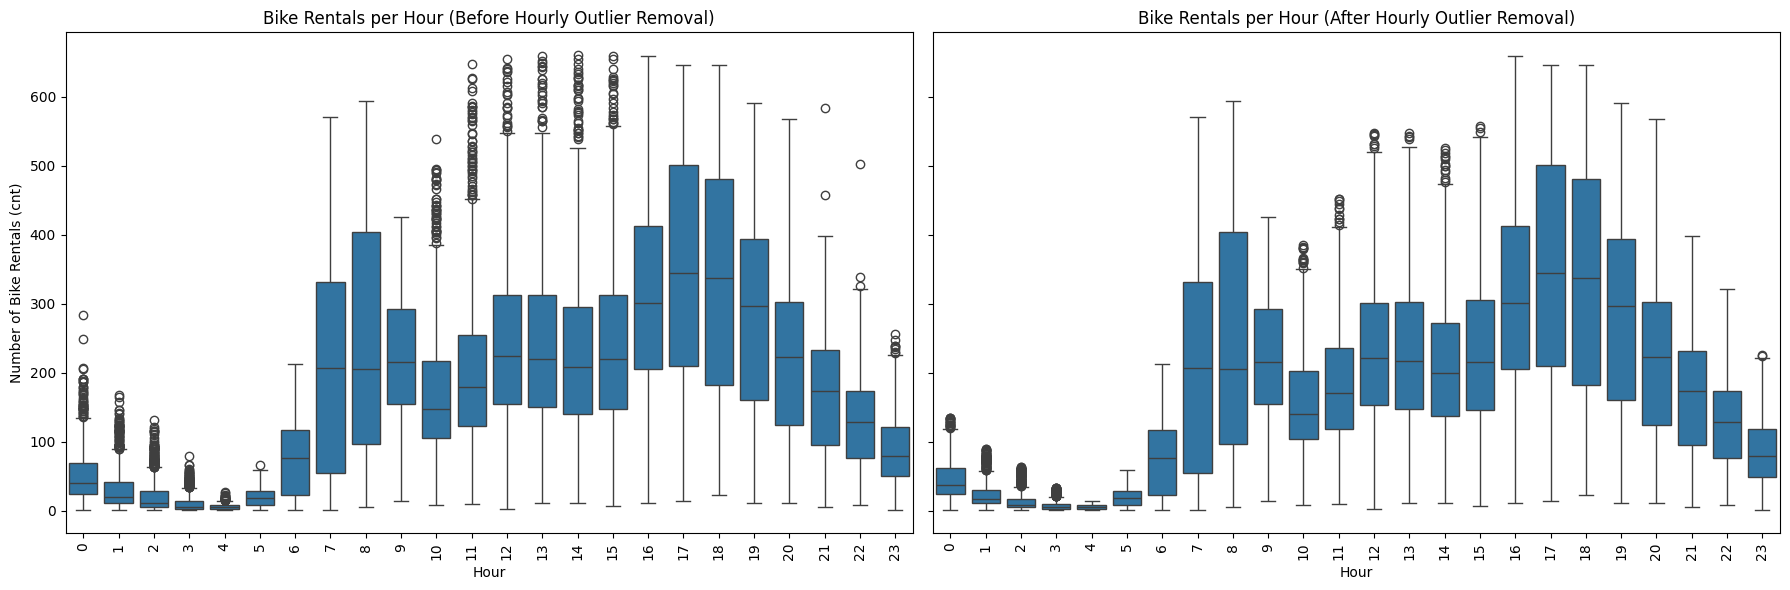

In [79]:
clean_df_before_hr_removal = clean_df.copy()

clean_df = clean_df.drop(outlier_indices_hr_unique)

print(f"Shape of clean_df after hourly outlier removal: {clean_df.shape}")

num_original_rows = clean_df_before_hr_removal.shape[0]
num_rows_after_removal = clean_df.shape[0]
num_removed_rows = num_original_rows - num_rows_after_removal

print(f"Number of rows removed (hourly specific): {num_removed_rows}")

fig, axes = plt.subplots(1, 2, figsize=(18, 6), sharey=True)

sns.boxplot(x='hr', y='cnt', data=clean_df_before_hr_removal, ax=axes[0])
axes[0].set_title('Bike Rentals per Hour (Before Hourly Outlier Removal)')
axes[0].set_xlabel('Hour')
axes[0].set_ylabel('Number of Bike Rentals (cnt)')
axes[0].set_xticks(range(0, 24))
axes[0].set_xticklabels(range(0, 24), rotation=90)

sns.boxplot(x='hr', y='cnt', data=clean_df, ax=axes[1])
axes[1].set_title('Bike Rentals per Hour (After Hourly Outlier Removal)')
axes[1].set_xlabel('Hour')
axes[1].set_ylabel('Number of Bike Rentals (cnt)')
axes[1].set_xticks(range(0, 24))
axes[1].set_xticklabels(range(0, 24), rotation=90)

plt.tight_layout()
plt.show()

In [81]:
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16095 entries, 0 to 17378
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   instant         16095 non-null  int64  
 1   dteday          16095 non-null  object 
 2   season          16095 non-null  int64  
 3   yr              16095 non-null  int64  
 4   mnth            16095 non-null  int64  
 5   hr              16095 non-null  int64  
 6   holiday         16095 non-null  int64  
 7   weekday         16095 non-null  int64  
 8   workingday      16095 non-null  int64  
 9   weathersit      16095 non-null  int64  
 10  temp            16095 non-null  float64
 11  atemp           16095 non-null  float64
 12  hum             16095 non-null  float64
 13  windspeed       16095 non-null  float64
 14  casual          16095 non-null  int64  
 15  registered      16095 non-null  int64  
 16  cnt             16095 non-null  int64  
 17  calculated_cnt  16095 non-null  int6

## Random Forest model re-evaluation


In [80]:
y_clean = clean_df['cnt']
X_clean = clean_df[['season', 'yr', 'mnth', 'hr', 'holiday',
        'weekday', 'temp', 'atemp', 'workingday', 'hum', 'windspeed',  'weathersit']]

cat_cols = ['season','yr','hr', 'mnth','workingday', 'weathersit', 'holiday', 'weekday']
num_cols = ['temp', 'hum', 'atemp', 'windspeed']
preproc_clean = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(drop='first', sparse_output=False), cat_cols)
])

rf_pipe_clean = Pipeline([
    ('preproc', preproc_clean),
    ('rf', RandomForestRegressor(
        n_estimators=100,
        random_state=42,
        max_depth=15))
])

X_train_clean, X_test_clean, y_train_clean, y_test_clean = train_test_split(X_clean, y_clean, test_size=0.3, random_state=42)

rf_pipe_clean.fit(X_train_clean, y_train_clean)

y_pred_train_clean = rf_pipe_clean.predict(X_train_clean)
y_pred_test_clean = rf_pipe_clean.predict(X_test_clean)

print(f'Train RMSE (cleaned data): {np.sqrt(mean_squared_error(y_train_clean, y_pred_train_clean)):.1f}')
print(f'Test RMSE (cleaned data): {np.sqrt(mean_squared_error(y_test_clean, y_pred_test_clean)):.1f}')
print(f'Test R² (cleaned data): {r2_score(y_test_clean, y_pred_test_clean):.3f}')
print(f'CV5 RMSE (cleaned data): {(-cross_val_score(rf_pipe_clean, X_clean, y_clean, cv=5, scoring="neg_root_mean_squared_error").mean()):.1f}')

importances_clean = pd.Series(rf_pipe_clean.named_steps['rf'].feature_importances_,
                       index=rf_pipe_clean.named_steps['preproc'].get_feature_names_out()).sort_values(ascending=False)
print('Top Features to determine "cnt" (cleaned data):\n', importances_clean)


Train RMSE (cleaned data): 53.9
Test RMSE (cleaned data): 65.3
Test R² (cleaned data): 0.793
CV5 RMSE (cleaned data): 80.9
Top Features to determine "cnt" (cleaned data):
 num__atemp           0.189691
num__hum             0.100579
num__temp            0.079926
cat__workingday_1    0.063210
cat__yr_1            0.051069
cat__hr_17           0.050002
cat__hr_18           0.043558
cat__hr_19           0.039629
cat__hr_1            0.035593
cat__hr_2            0.034197
cat__hr_4            0.033777
cat__hr_3            0.031484
cat__hr_8            0.030381
cat__hr_5            0.029928
cat__hr_16           0.025244
cat__hr_7            0.021695
cat__season_4        0.018864
cat__hr_23           0.014629
cat__hr_9            0.012785
num__windspeed       0.011770
cat__hr_6            0.011652
cat__hr_20           0.010736
cat__weathersit_3    0.010118
cat__weekday_5       0.004400
cat__weekday_6       0.002960
cat__hr_12           0.002589
cat__hr_13           0.002290
cat__mnth_12      

In [82]:
# We intend to make a second model to test if with all the variables we get better results

y = clean_df['cnt']
X = clean_df[['season', 'yr', 'mnth', 'hr', 'holiday',
        'weekday', 'temp', 'atemp', 'workingday', 'hum', 'windspeed',  'weathersit',]]

cat_cols = ['season','yr','hr', 'mnth','workingday', 'weathersit', 'holiday', 'weekday']
num_cols = ['temp', 'hum', 'atemp', 'windspeed']
preproc = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(drop='first', sparse_output=False), cat_cols)
])

rf_pipe = Pipeline([
    ('preproc', preproc),
    ('rf', RandomForestRegressor(
        n_estimators=100, # number of trees
        random_state=42,  # random number to choose lines from the dataset
        max_depth=15))    # number of levels of decision
])


# Split into train and test
# We will use ~70% of the dataset to train and the rest to test (30%)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


# Using the trees we have already defined, the program use them to train
# NOTE that we are only training in here

rf_pipe.fit(X_train, y_train)


# We start to use the model to predict the "cnt"

y_pred_train = rf_pipe.predict(X_train) # Predict based on the training
y_pred_test = rf_pipe.predict(X_test)   # Predict numbers that have never "seen"

print(f'Train RMSE: {np.sqrt(mean_squared_error(y_train, y_pred_train)):.1f}')
print(f'Test RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_test)):.1f}')
print(f'Test R²: {r2_score(y_test, y_pred_test):.3f}')
print(f'CV5 RMSE: {(-cross_val_score(rf_pipe, X, y, cv=5, scoring="neg_root_mean_squared_error").mean()):.1f}')


# Features more relevant
importances = pd.Series(rf_pipe.named_steps['rf'].feature_importances_,
                       index=rf_pipe.named_steps['preproc'].get_feature_names_out()).sort_values(ascending=False)
print('Top Features to determine "cnt":\n', importances)


# Model saved
joblib.dump(rf_pipe, 'clean_model.pkl')
print('Modelo salvo: clean_model.pkl')


Train RMSE: 53.9
Test RMSE: 65.3
Test R²: 0.793
CV5 RMSE: 80.9
Top Features to determine "cnt":
 num__atemp           0.189691
num__hum             0.100579
num__temp            0.079926
cat__workingday_1    0.063210
cat__yr_1            0.051069
cat__hr_17           0.050002
cat__hr_18           0.043558
cat__hr_19           0.039629
cat__hr_1            0.035593
cat__hr_2            0.034197
cat__hr_4            0.033777
cat__hr_3            0.031484
cat__hr_8            0.030381
cat__hr_5            0.029928
cat__hr_16           0.025244
cat__hr_7            0.021695
cat__season_4        0.018864
cat__hr_23           0.014629
cat__hr_9            0.012785
num__windspeed       0.011770
cat__hr_6            0.011652
cat__hr_20           0.010736
cat__weathersit_3    0.010118
cat__weekday_5       0.004400
cat__weekday_6       0.002960
cat__hr_12           0.002589
cat__hr_13           0.002290
cat__mnth_12         0.002115
cat__mnth_3          0.002103
cat__weathersit_2    0.001990
cat

RMSE original all: 88.52
R² original all: 0.762

Correct vs Wrong by Category (All Variables):
correct          False  True  % correct
cnt_cat                                
Low Movement      1201  3675       75.4
Medium Movement   2495  3413       57.8
High Movement     2692  3903       59.2


/tmp/ipython-input-2172565527.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  resumo = br_with_pred.groupby(['cnt_cat', 'correct']).size().unstack(fill_value=0)


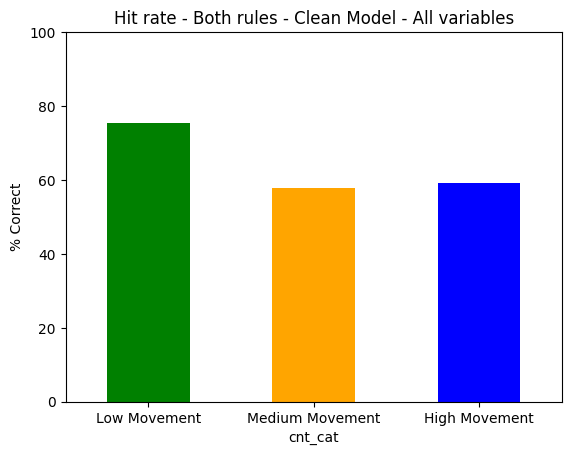


Total Corrects All Model: 63.2%


In [85]:
model_all = joblib.load('clean_model.pkl')

X_full = df[['season', 'yr', 'mnth', 'hr', 'holiday',
        'weekday', 'temp', 'atemp', 'workingday', 'hum', 'windspeed',  'weathersit']]
br_with_pred = br.copy()

br_with_pred['pred'] = model_all.predict(X_full)

rmse = np.sqrt(mean_squared_error(br_with_pred['cnt'], br_with_pred['pred']))
print(f"RMSE original all: {rmse:.2f}")
print(f"R² original all: {r2_score(br_with_pred['cnt'], br_with_pred['pred']):.3f}")

br_with_pred['erro_abs'] = abs(br_with_pred['pred'] - br_with_pred['cnt'])
br_with_pred['erro_pct'] = br_with_pred['erro_abs'] / br_with_pred['cnt'].replace(0,1) * 100  # Evita /0
br_with_pred['correct'] = (br_with_pred['erro_pct'] < 20) | (br_with_pred['erro_abs'] < 30)
br_with_pred['cnt_cat'] = pd.cut(br_with_pred['cnt'], bins=[0,50,200,1000],
                                 labels=['Low Movement','Medium Movement','High Movement'])

resumo = br_with_pred.groupby(['cnt_cat', 'correct']).size().unstack(fill_value=0)
resumo['% correct'] = resumo[True] / (resumo[True] + resumo[False]) * 100
print("\nCorrect vs Wrong by Category (All Variables):")
print(resumo.round(1))

resumo['% correct'].plot(kind='bar', color=['green','orange','blue'])
plt.title('Hit rate - Both rules - Clean Model - All variables')
plt.ylabel('% Correct'); plt.ylim(0,100)
plt.xticks(rotation=0)
plt.show()

print(f"\nTotal Corrects All Model: {br_with_pred['correct'].mean()*100:.1f}%")

RMSE original all: 88.52
R² original all: 0.762

Correct vs Wrong by Category (All Variables):
correct          False  True  % correct
cnt_cat                                
Low Movement      3859  1017       20.9
Medium Movement   3148  2760       46.7
High Movement     2692  3903       59.2


/tmp/ipython-input-573024484.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  resumo = br_with_pred.groupby(['cnt_cat', 'correct']).size().unstack(fill_value=0)


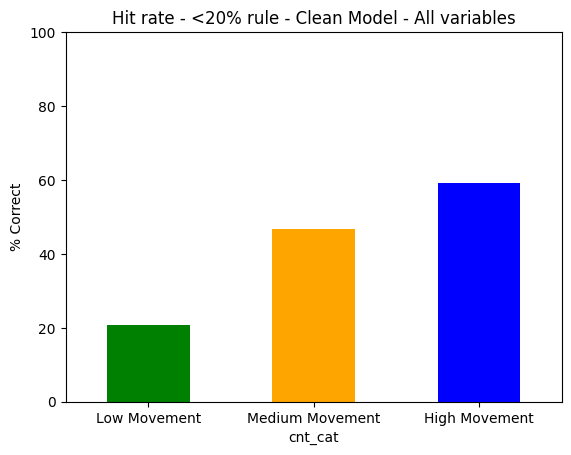


Total Corrects All Model: 44.2%


In [86]:
model_all = joblib.load('clean_model.pkl')

X_full = df[['season', 'yr', 'mnth', 'hr', 'holiday',
        'weekday', 'temp', 'atemp', 'workingday', 'hum', 'windspeed',  'weathersit']]
br_with_pred = br.copy()

br_with_pred['pred'] = model_all.predict(X_full)

rmse = np.sqrt(mean_squared_error(br_with_pred['cnt'], br_with_pred['pred']))
print(f"RMSE original all: {rmse:.2f}")
print(f"R² original all: {r2_score(br_with_pred['cnt'], br_with_pred['pred']):.3f}")

br_with_pred['erro_abs'] = abs(br_with_pred['pred'] - br_with_pred['cnt'])
br_with_pred['erro_pct'] = br_with_pred['erro_abs'] / br_with_pred['cnt'].replace(0,1) * 100  # Evita /0
br_with_pred['correct'] = (br_with_pred['erro_pct'] < 20)
br_with_pred['cnt_cat'] = pd.cut(br_with_pred['cnt'], bins=[0,50,200,1000],
                                 labels=['Low Movement','Medium Movement','High Movement'])

resumo = br_with_pred.groupby(['cnt_cat', 'correct']).size().unstack(fill_value=0)
resumo['% correct'] = resumo[True] / (resumo[True] + resumo[False]) * 100
print("\nCorrect vs Wrong by Category (All Variables):")
print(resumo.round(1))

resumo['% correct'].plot(kind='bar', color=['green','orange','blue'])
plt.title('Hit rate - <20% rule - Clean Model - All variables')
plt.ylabel('% Correct'); plt.ylim(0,100)
plt.xticks(rotation=0)
plt.show()

print(f"\nTotal Corrects All Model: {br_with_pred['correct'].mean()*100:.1f}%")

RMSE original all: 88.52
R² original all: 0.762

Correct vs Wrong by Category (All Variables):
correct          False  True  % correct
cnt_cat                                
Low Movement      1201  3675       75.4
Medium Movement   2568  3340       56.5
High Movement     4361  2234       33.9


/tmp/ipython-input-54710938.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  resumo = br_with_pred.groupby(['cnt_cat', 'correct']).size().unstack(fill_value=0)


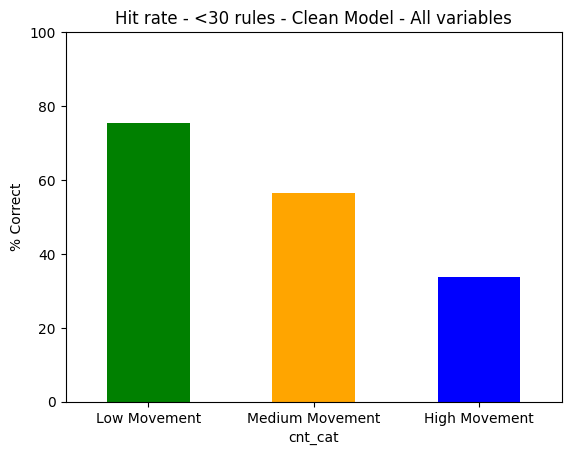


Total Corrects All Model: 53.2%


In [87]:
model_all = joblib.load('clean_model.pkl')

X_full = df[['season', 'yr', 'mnth', 'hr', 'holiday',
        'weekday', 'temp', 'atemp', 'workingday', 'hum', 'windspeed',  'weathersit']]
br_with_pred = br.copy()

br_with_pred['pred'] = model_all.predict(X_full)

rmse = np.sqrt(mean_squared_error(br_with_pred['cnt'], br_with_pred['pred']))
print(f"RMSE original all: {rmse:.2f}")
print(f"R² original all: {r2_score(br_with_pred['cnt'], br_with_pred['pred']):.3f}")

br_with_pred['erro_abs'] = abs(br_with_pred['pred'] - br_with_pred['cnt'])
br_with_pred['erro_pct'] = br_with_pred['erro_abs'] / br_with_pred['cnt'].replace(0,1) * 100  # Evita /0
br_with_pred['correct'] = (br_with_pred['erro_abs'] < 30)
br_with_pred['cnt_cat'] = pd.cut(br_with_pred['cnt'], bins=[0,50,200,1000],
                                 labels=['Low Movement','Medium Movement','High Movement'])

resumo = br_with_pred.groupby(['cnt_cat', 'correct']).size().unstack(fill_value=0)
resumo['% correct'] = resumo[True] / (resumo[True] + resumo[False]) * 100
print("\nCorrect vs Wrong by Category (All Variables):")
print(resumo.round(1))

resumo['% correct'].plot(kind='bar', color=['green','orange','blue'])
plt.title('Hit rate - <30 rules - Clean Model - All variables')
plt.ylabel('% Correct'); plt.ylim(0,100)
plt.xticks(rotation=0)
plt.show()

print(f"\nTotal Corrects All Model: {br_with_pred['correct'].mean()*100:.1f}%")

## Analysis

This last atempt to increase the evaluation aspect of the model didn't brought any value, in fact, when we look at each overall, a "dirty" all variables model, still has the better rates of prediction